# Optimized Cellular Potts Model

The CPM can be imported as a standard python module.

In [17]:
import matplotlib.pyplot as plt
import matplotlib.animation
import cpm
import numpy as np
import seaborn as sns
import pandas as pd

The simulation parameters are set in Python.

In [3]:
def create_simulation():
    temperature = 20
    number_of_types = 2 # includes background as type
    dimension = 1024 # currently can only simulate square domains, dimension needs to be power of 2
    simulation = cpm.Cpm(dimension, number_of_types, temperature)
    simulation.add_cell(dimension//2, dimension//2)
    simulation.set_constraints(cell_type = 1, lambda_perimeter = 2, target_perimeter = 340)
    simulation.set_constraints(cell_type = 1, lambda_area = 50, target_area = 500)
    simulation.set_constraints(cell_type = 1, lambda_act = 200, max_act = 40)
    simulation.set_constraints(cell_type = 1, other_cell_type = 1, adhesion = 100)
    simulation.set_constraints(cell_type = 0, other_cell_type = 1, adhesion = 20)
    return simulation

We can have the CPM run for a full simulation run of however many MCSs we desire. Here however we let it only run for 5 MCSs at a time so we can save of the internal state. The cell state (where each cell will have a unique number) is returned as a NumPy array, but contains the actual internal state of the array that is used by the C++ code. This makes it somewhat dangerous and necessitates the copying of arrays in Python code. It is however also quite efficient should the internal arrays get big and would allow for direct manipulation of the internal state of the C++ code in Python if desired. 

In [4]:
simulation = create_simulation()
results = []
for i in range(100):
    simulation.run(5)
    results.append(np.copy(simulation.get_state()))

The sequence of saved of internal CPM states can be animated to check if the CPM is doing something sensible.

<IPython.core.display.Javascript object>


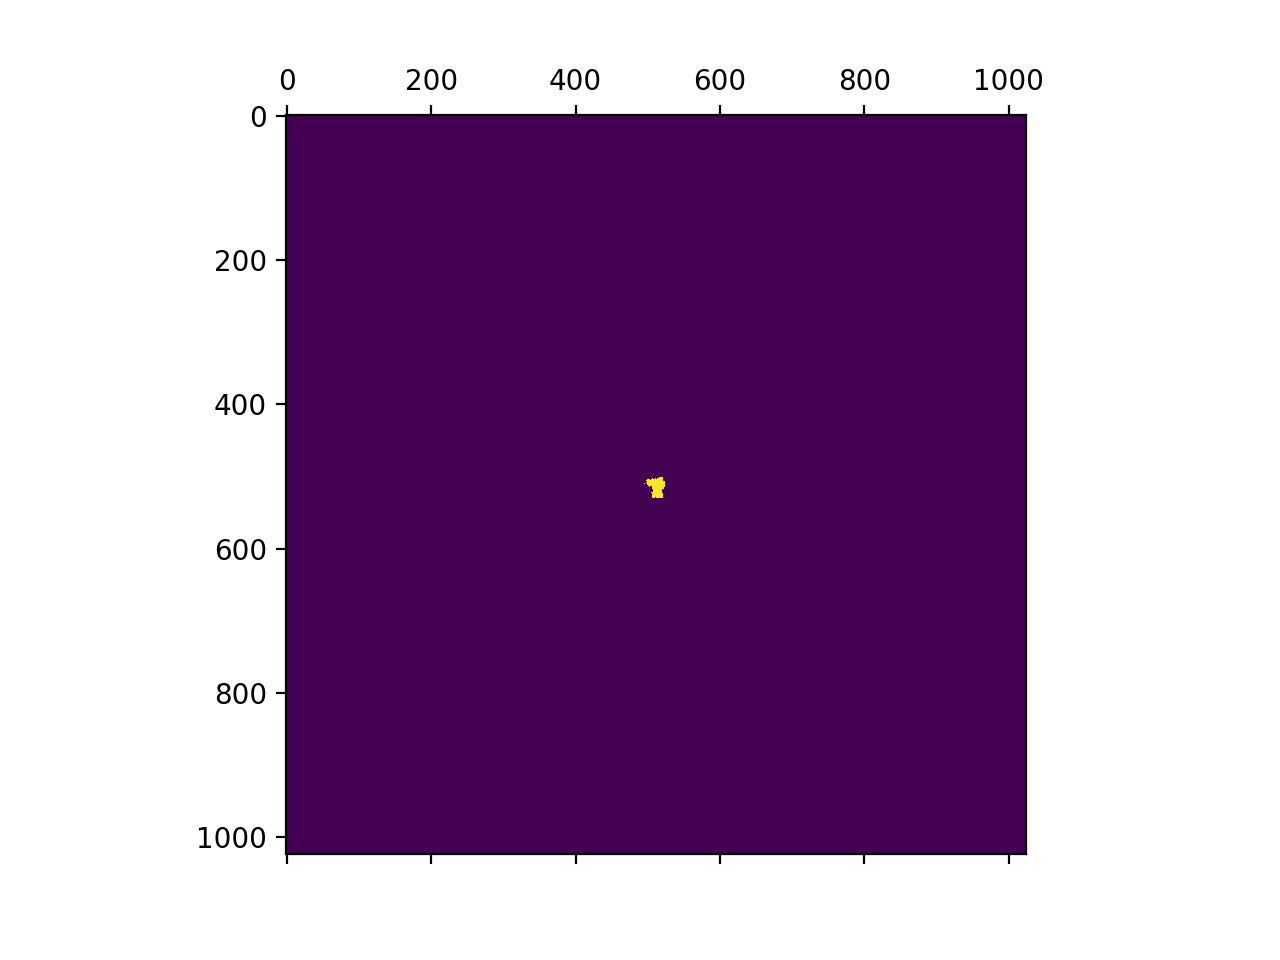

In [5]:
%matplotlib notebook
fig, ax = plt.subplots()
l = ax.matshow(results[0])
def animate(i):
    l.set_data(results[i])
ani = matplotlib.animation.FuncAnimation(fig, animate, frames=len(results))

In addition to the standard run() method there also is a run_async() method. This will spin up a thread in the background to run the simulation and then immediately return. To ensure that it is safe to access a simulation's internal state we can do a join on a simulation to ensure it has finished running. More complicated thread orchestration could be implemented in Python, where e.g. 1000 simulations need to be run but you only want to have 10 running at the same time.

In [14]:
simulations = []
for i in range(10):
    simulation = create_simulation()
    simulation.run_async(50000)
    simulations.append(simulation)
for simulation in simulations:
    simulation.join()

To get a sense of what the different simulations did we can get the final state for all simulations and animate them.

<IPython.core.display.Javascript object>


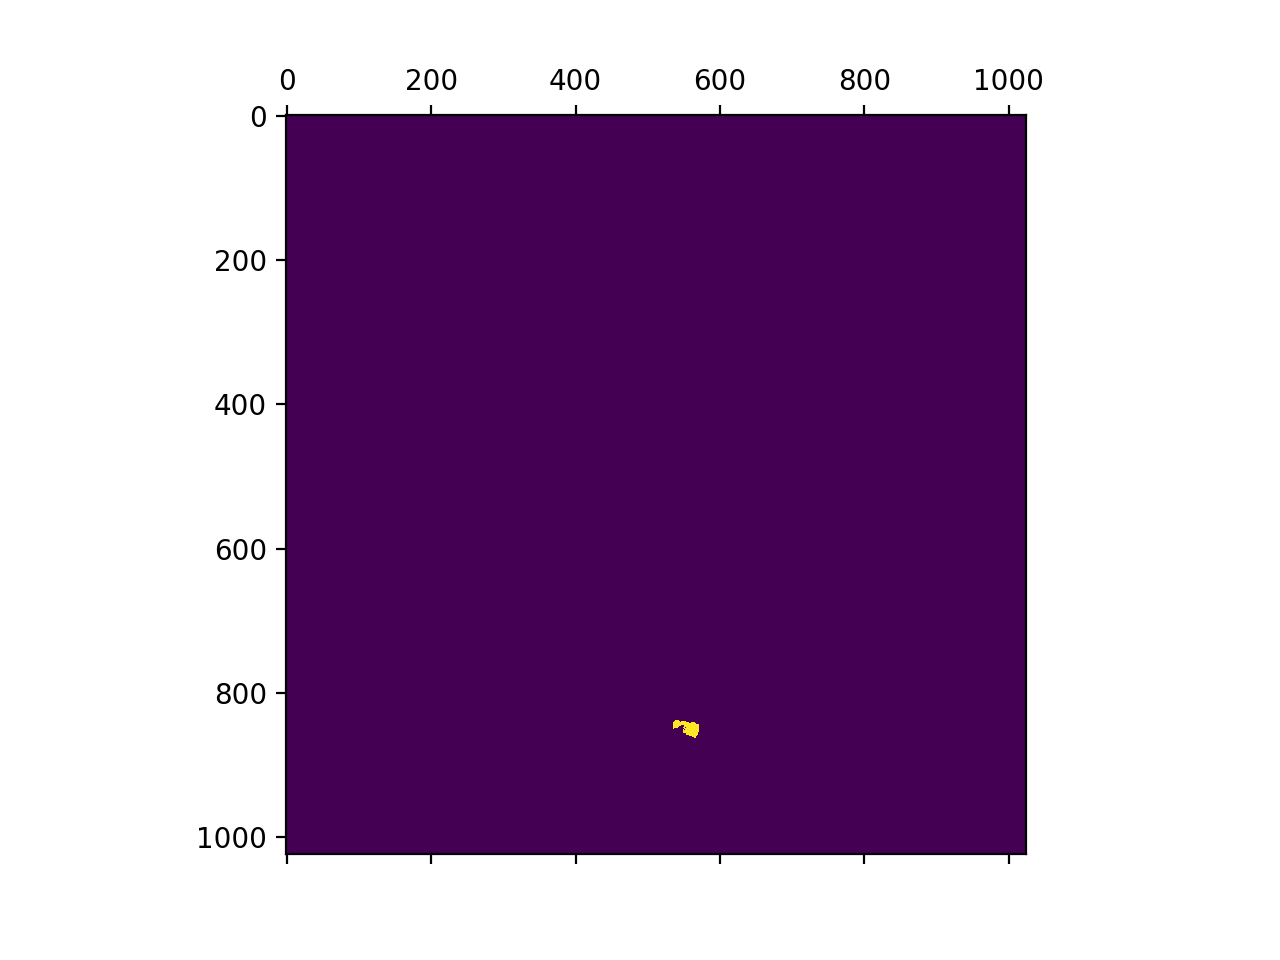

In [7]:
%matplotlib notebook
fig, ax = plt.subplots()
results = [i.get_state() for i in simulations]
l = ax.matshow(results[0])
def animate(i):
    l.set_data(results[i])
ani = matplotlib.animation.FuncAnimation(fig, animate, frames=len(results))

To get a sense of the scanning behaviour we could use the internal act lattice state and show where a cell for a particular simulation has travelled.

<IPython.core.display.Javascript object>


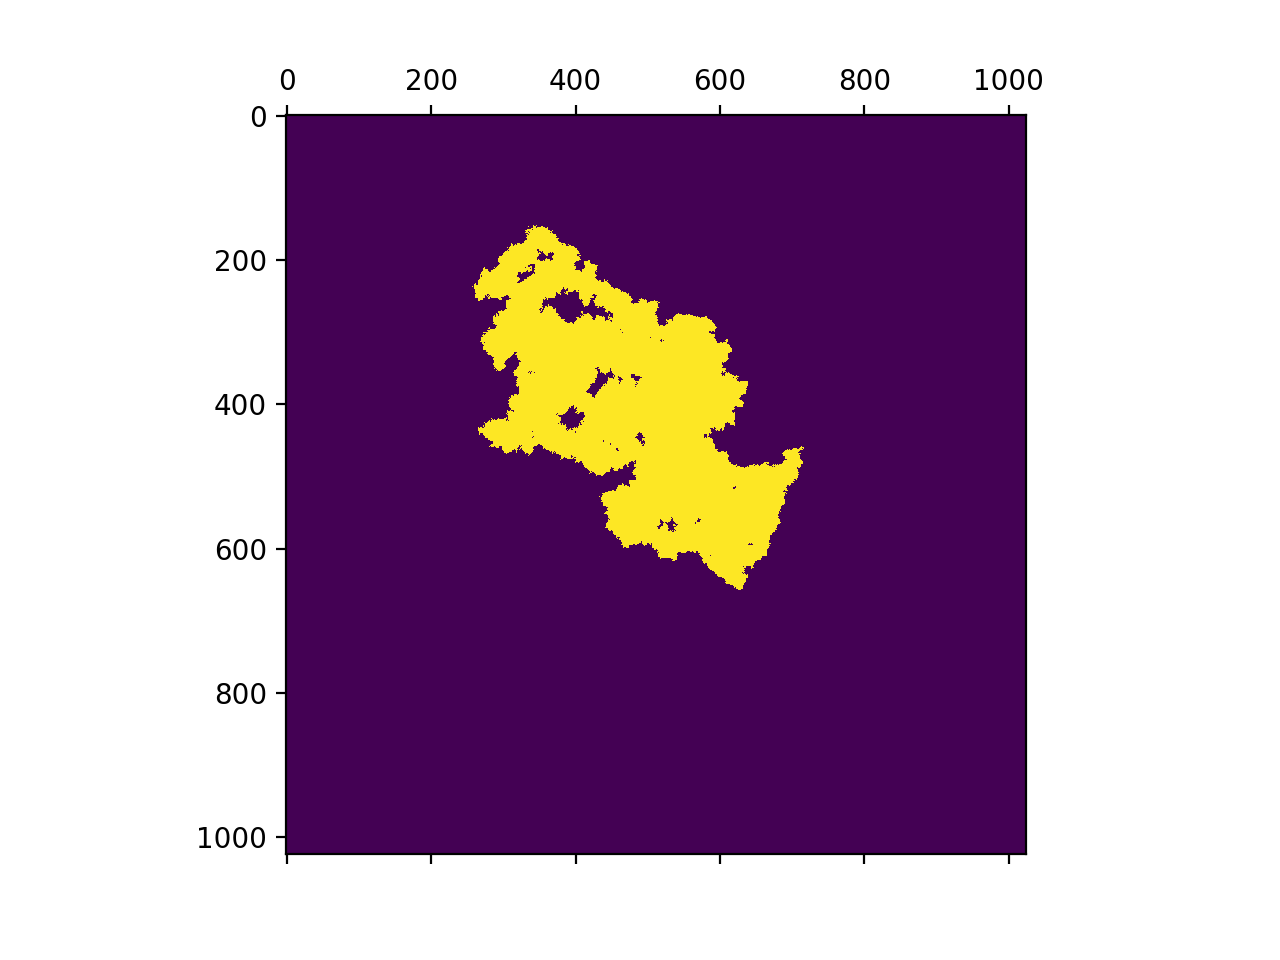

In [8]:
%matplotlib notebook
fig, ax = plt.subplots()
results = [i.get_act_state() > 0 for i in simulations]
l = ax.matshow(results[0])
def animate(i):
    l.set_data(results[i])
ani = matplotlib.animation.FuncAnimation(fig, animate, frames=len(results))

We can calculate what the percentage of area covered is by a cell and get a sense of how consistent the scanning behaviour is.

<IPython.core.display.Javascript object>


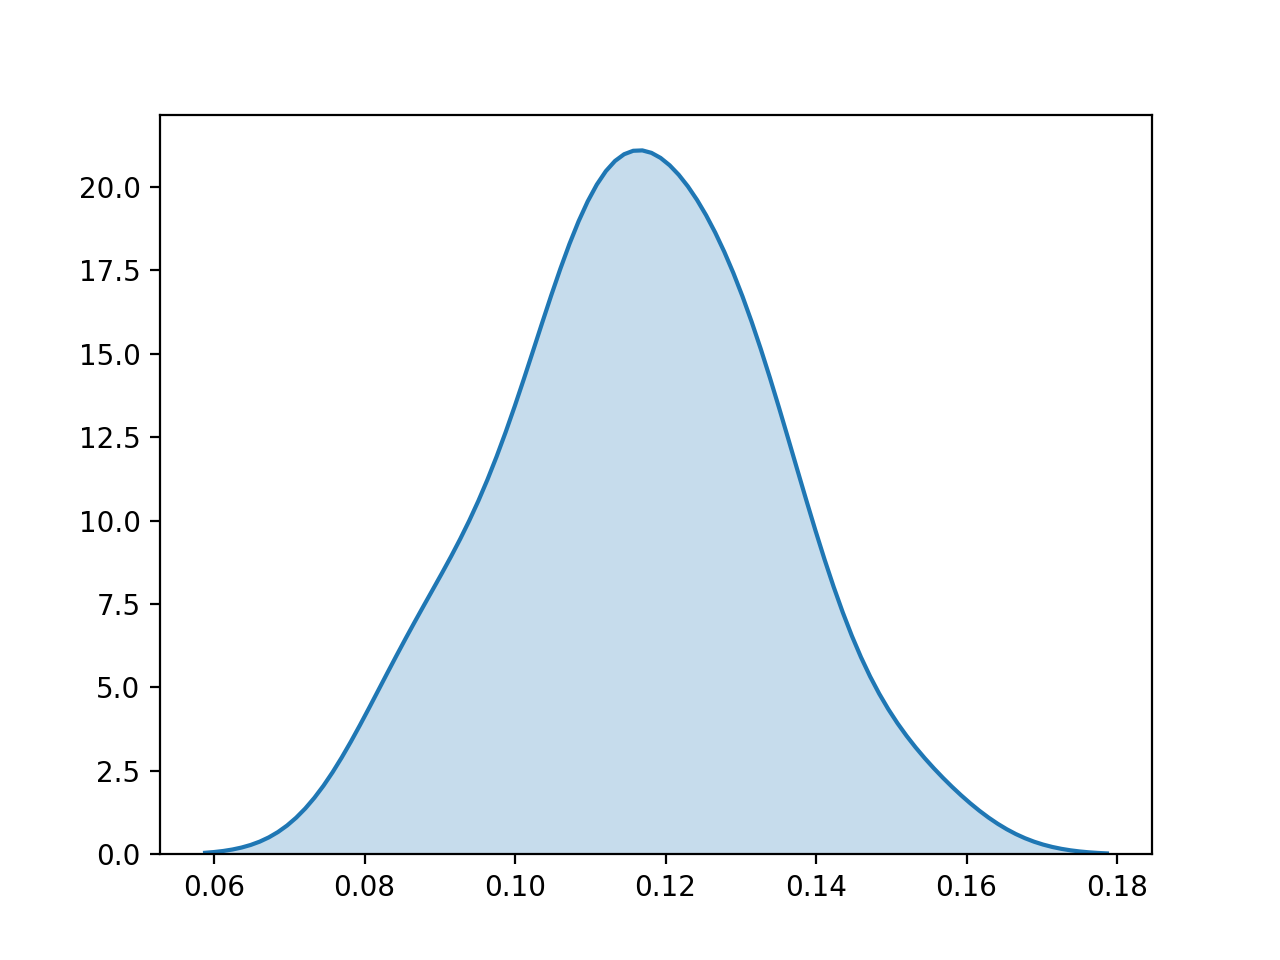

In [16]:
scanned_area_percentages = []
for simulation in simulations:
    scanned_area = simulation.get_act_state() > 0
    area_percentage = scanned_area.sum() / scanned_area.size
    scanned_area_percentages.append(area_percentage)
sns.kdeplot(scanned_area_percentages, shade=True)

Finally let's run a slightly more complicated simulation where we try to have different simulations in terms of cellular speed/persistence and see what the result of the scanning behaviour is. Simulation parameters taken from "Both cell-intrinsic and environmental factors constrain speed and persistence in T cell migration". 

In [20]:
def create_simulation(lambda_act):
    temperature = 20
    number_of_types = 2 # includes background as type
    dimension = 1024 # currently can only simulate square domains, dimension needs to be power of 2
    simulation = cpm.Cpm(dimension, number_of_types, temperature)
    simulation.add_cell(dimension//2, dimension//2)
    simulation.set_constraints(cell_type = 1, lambda_perimeter = 2, target_perimeter = 260)
    simulation.set_constraints(cell_type = 1, lambda_area = 30, target_area = 500)
    simulation.set_constraints(cell_type = 1, lambda_act = lambda_act, max_act = 100)
    simulation.set_constraints(cell_type = 1, other_cell_type = 1, adhesion = 100)
    simulation.set_constraints(cell_type = 0, other_cell_type = 1, adhesion = 20)
    return simulation

def run_simulations(lambda_act):
    simulations_per_lambda = 5
    simulations = []
    for i in range(simulations_per_lambda):
        simulation = create_simulation(lambda_act)
        simulation.run_async(50000)
        simulations.append(simulation)
    for simulation in simulations:
        simulation.join()
    return simulations

def get_area_percentage(simulation):
    scanned_area = simulation.get_act_state() > 0
    return scanned_area.sum() / scanned_area.size

lambda_acts = [30, 35, 40, 45, 50, 60, 70, 100, 150, 200]
area_percentages = []

In [23]:
for l in lambda_acts:
    simulations = run_simulations(l)
    area_scanned = np.average([get_area_percentage(simulation) for simulation in simulations])
    area_percentages.append(area_scanned)

<IPython.core.display.Javascript object>


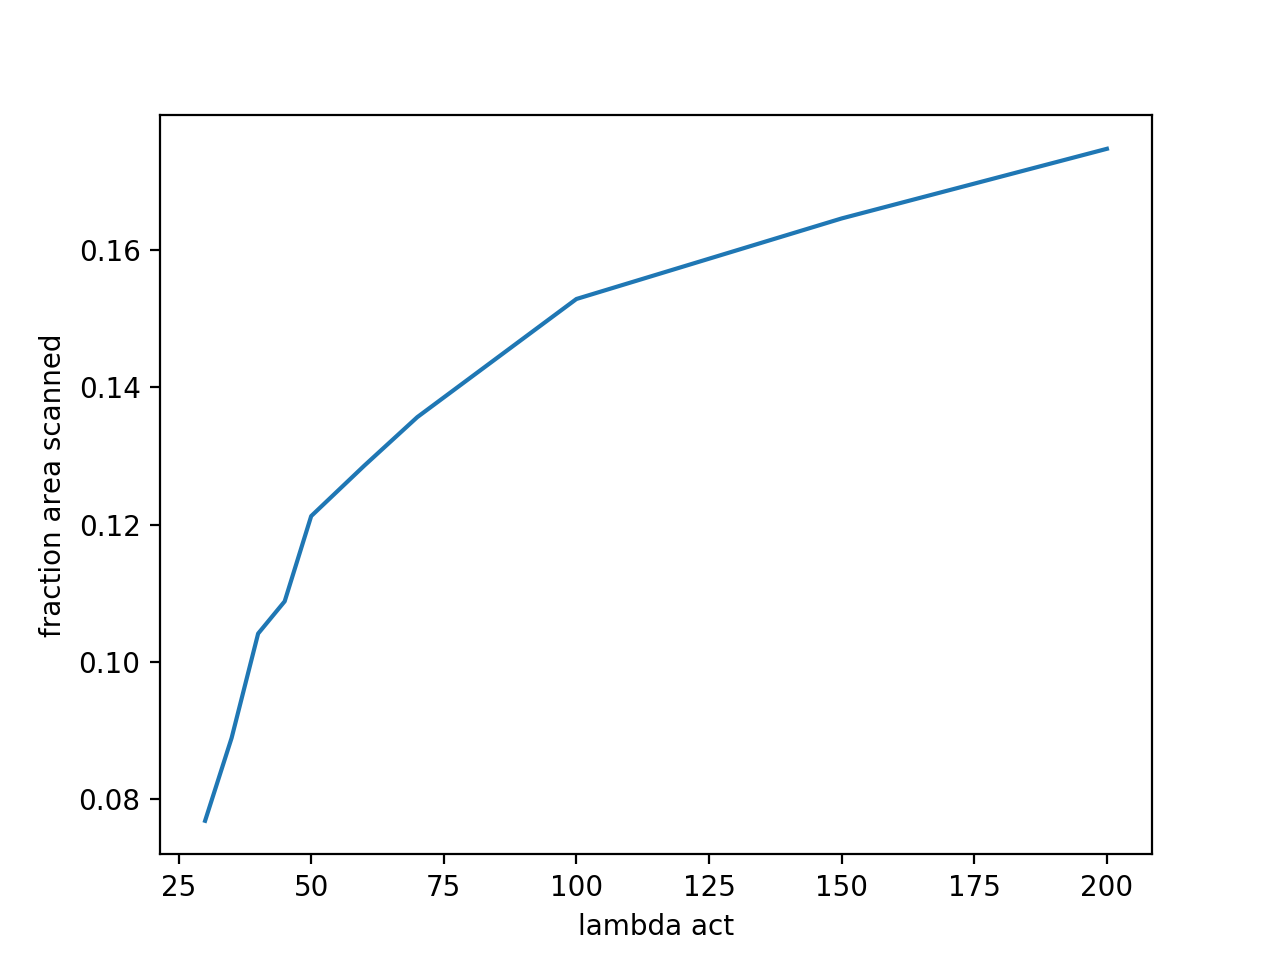

In [28]:
plt.xlabel("lambda act")
plt.ylabel("fraction area scanned")
plt.plot(lambda_acts, area_percentages)